In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
os.environ['PROJ_LIB'] = r'C:/Users/mastr/miniconda3/pkgs/proj4-5.2.0-ha925a31_1/Library/share'
import glob
import numpy as np
import pandas as pd
#from scipy import interpolate
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

In [2]:
## Function for creating a path, if needed ##
def checkDir(out_path):
    if not os.path.exists(out_path):
        os.makedirs(out_path)

def gwpstar(arr,coeff1,coeff2,gwp100):
    arr_init = coeff1*arr[0:19]*gwp100
    gwparr = np.copy(arr)
    gwparr[20:gwparr.shape[0]] = coeff1*(arr[20:arr.shape[0]]*gwp100)-coeff2*(arr[0:gwparr.shape[0]-20]*gwp100)
    gwparr[0:19] = arr_init
    return(gwparr)

#### ======== Set the paths ========####

# Path for netcdf files
data_path = 'C:/Users/mastr/Documents/LSCE/Carbon Budget'                         ## WINDOWS
#data_path = '/Users/mmastro/Documents/LSCE/Carbon Budget'               ## MAC OS

# Path for the output files (images, etc)
out_path = "C:/Users/mastr/Documents/LSCE/RESULTS/Carbon_Budget_BETA&Q10_COU"
#out_path = '/Users/mmastro/Documents/LSCE/RESULTS'


## Constants
MttoGt = 0.001
CtoCO2 = 44/12
NtoN2O = 44/14
CO2toC = 12/44

## Simulations with alternate fixed CH4 and CO2 emissions

### IPSL emulation with BETA=0.3 to demonstrate effect of CO2 fertilizatoin on carbon budget

## CO2 calculation

In [9]:
## OVERSHOOT ESTIMATION ##
import matplotlib.gridspec as gridspec
%matplotlib inline

# Choose model to plot:
# cnrm; ipsl; miroc; ukesm
model = "ipsl"

simulations = [2090, 2100, 2110, 2120, 2130, 2140, 2150, 2160, 2170, 2180, 2190]

## -- TEMPERATURE
folder = "/CarbonBudget_BETA_03/CO2_15/"
file = "T2M_15_BETA03_" + model + ".csv"
df_acc2_tas_co2_15=pd.read_csv(os.path.join(data_path+folder+file), header=0)
df_acc2_tas_co2_15.columns = [0, 2120, 2130, 2140, 2150, 2160, 2170, 2180, 2190, 2090, 2100, 2110]; tas_co2_15_acc2 = df_acc2_tas_co2_15.drop(columns=[0]); tas_co2_15_acc2 = tas_co2_15_acc2.reindex(columns=simulations)

folder = "/CarbonBudget_BETA_03/CO2_20/"
file = "T2M_20_BETA03_" + model + ".csv"
df_acc2_tas_co2_20=pd.read_csv(os.path.join(data_path+folder+file), header=0)
df_acc2_tas_co2_20.columns = [0, 1, 2120, 2130, 2140, 2150, 2160, 2170, 2180, 2190, 2090, 2100, 2110]; tas_co2_20_acc2 = df_acc2_tas_co2_20.drop(columns=[0,1]); tas_co2_20_acc2 = tas_co2_20_acc2.reindex(columns=simulations)

## -- EMISSIONS
folder = "/CarbonBudget_BETA_03/CO2_15/"
file = "CO2_15_BETA03_" + model + ".csv"
df_acc2_co2_15=pd.read_csv(os.path.join(data_path+folder+file), header=0)
df_acc2_co2_15.columns = [0, 2120, 2130, 2140, 2150, 2160, 2170, 2180, 2190, 2090, 2100, 2110]; co2_15_acc2 = df_acc2_co2_15.drop(columns=[0]); co2_15_acc2 = co2_15_acc2.reindex(columns=simulations)

folder = "/CarbonBudget_BETA_03/CO2_20/"
file = "CO2_20_BETA03_" + model + ".csv"
df_acc2_co2_20=pd.read_csv(os.path.join(data_path+folder+file), header=0)
df_acc2_co2_20.columns = [0,1,2120, 2130, 2140, 2150, 2160, 2170, 2180, 2190, 2090, 2100, 2110]; co2_20_acc2 = df_acc2_co2_20.drop(columns=[0,1]); co2_20_acc2 = co2_20_acc2.reindex(columns=simulations)


## -- Unit conversion
co2_15_acc2 = co2_15_acc2.to_numpy()                        #GtC
co2_20_acc2 = co2_20_acc2.to_numpy()                        #GtC

## -- Cumulative emissions
co2cum_15_acc2 = np.cumsum(co2_15_acc2,axis=0)
co2cum_20_acc2 = np.cumsum(co2_20_acc2,axis=0)


## --  Controlling for UNFEASIBLE simulations
if model == "ipsl":
    co2_15_acc2=np.delete(co2_15_acc2,[0,1,2,3], axis = 1)
    co2cum_15_acc2=np.delete(co2cum_15_acc2,[0,1,2], axis = 1)
    tas_co2_15_acc2= tas_co2_15_acc2.drop(columns=[2090, 2100, 2110, 2120])

######### --- Estimation of Overshoot exceedance --- #########
# Retrieve index of last data before Overshoot
bf_OS_co2_15_em = (tas_co2_15_acc2>=1.5).idxmax()-1
bf_OS_co2_20_em = (tas_co2_20_acc2>=2).idxmax()-1

# Retrieve index of Peak Temperature
peak_co2_15_tas = (tas_co2_15_acc2).idxmax()
peak_co2_20_tas = (tas_co2_20_acc2).idxmax()

######### --- Calculation of OS of EMISSIONS amount --- #########
# Overshoot amount CO2_15
OS_co2_15 = np.empty(tas_co2_15_acc2.shape[1])
for i in np.arange(0,tas_co2_15_acc2.shape[1]):
    OS_co2_15[i] = co2cum_15_acc2[peak_co2_15_tas.to_numpy()[i],i] - co2cum_15_acc2[bf_OS_co2_15_em.to_numpy()[i],i]

# Overshoot amount CO2_20
OS_co2_20 = np.empty(tas_co2_20_acc2.shape[1])
for i in np.arange(0,co2_20_acc2.shape[1]):
    OS_co2_20[i] = co2cum_20_acc2[peak_co2_20_tas.to_numpy()[i],i] - co2cum_20_acc2[bf_OS_co2_20_em.to_numpy()[i],i]


In [10]:
import matplotlib.gridspec as gridspec
%matplotlib inline

model = "ipsl"
simulations = [2090, 2100, 2110, 2120, 2130, 2140, 2150, 2160, 2170, 2180, 2190]

## -- TEMPERATURE
folder = "/CarbonBudget_BETA_03/CO2_15/"
file = "T2M_15_BETA03_" + model + ".csv"
df_acc2_tas_co2_15=pd.read_csv(os.path.join(data_path+folder+file), header=0)
df_acc2_tas_co2_15.columns = [0, 2120, 2130, 2140, 2150, 2160, 2170, 2180, 2190, 2090, 2100, 2110]; tas_co2_15_acc2 = df_acc2_tas_co2_15.drop(columns=[0]); tas_co2_15_acc2 = tas_co2_15_acc2.reindex(columns=simulations)

folder = "/CarbonBudget_BETA_03/CO2_20/"
file = "T2M_20_BETA03_" + model + ".csv"
df_acc2_tas_co2_20=pd.read_csv(os.path.join(data_path+folder+file), header=0)
df_acc2_tas_co2_20.columns = [0, 1, 2120, 2130, 2140, 2150, 2160, 2170, 2180, 2190, 2090, 2100, 2110]; tas_co2_20_acc2 = df_acc2_tas_co2_20.drop(columns=[0,1]); tas_co2_20_acc2 = tas_co2_20_acc2.reindex(columns=simulations)

## -- EMISSIONS
folder = "/CarbonBudget_BETA_03/CO2_15/"
file = "CO2_15_BETA03_" + model + ".csv"
df_acc2_co2_15=pd.read_csv(os.path.join(data_path+folder+file), header=0)
df_acc2_co2_15.columns = [0, 2120, 2130, 2140, 2150, 2160, 2170, 2180, 2190, 2090, 2100, 2110]; co2_15_acc2 = df_acc2_co2_15.drop(columns=[0]); co2_15_acc2 = co2_15_acc2.reindex(columns=simulations)

folder = "/CarbonBudget_BETA_03/CO2_20/"
file = "CO2_20_BETA03_" + model + ".csv"
df_acc2_co2_20=pd.read_csv(os.path.join(data_path+folder+file), header=0)
df_acc2_co2_20.columns = [0,1,2120, 2130, 2140, 2150, 2160, 2170, 2180, 2190, 2090, 2100, 2110]; co2_20_acc2 = df_acc2_co2_20.drop(columns=[0,1]); co2_20_acc2 = co2_20_acc2.reindex(columns=simulations)

## -- Convert CO2 from GtC to GtCO2
co2_15_acc2 = co2_15_acc2#*CtoCO2
co2_20_acc2 = co2_20_acc2#*CtoCO2

## -- EMISSIONS of CH4 and N20 (SSP119 and SSP126)
file = "/ssp119_CH4" + ".csv"
df_acc2_ch4_ssp119=pd.read_csv(os.path.join(data_path+file)); ch4_ssp119 = df_acc2_ch4_ssp119.drop(columns=["Unnamed: 0"])
file = "/ssp126_CH4" + ".csv"
df_acc2_ch4_ssp126=pd.read_csv(os.path.join(data_path+file)); ch4_ssp126 = df_acc2_ch4_ssp126.drop(columns=["Unnamed: 0"])
file = "/ssp119_N2O" + ".csv"
df_acc2_n2o_ssp119=pd.read_csv(os.path.join(data_path+file)); n2o_ssp119 = df_acc2_n2o_ssp119.drop(columns=["Unnamed: 0"])
file = "/ssp126_N2O" + ".csv"
df_acc2_n2o_ssp126=pd.read_csv(os.path.join(data_path+file)); n2o_ssp126 = df_acc2_n2o_ssp126.drop(columns=["Unnamed: 0"])


## ------------------------------- ##
## Adding CH4 and N2O to CO2 emissions

ch4_ssp119 = ch4_ssp119.to_numpy(); n2o_ssp119 = n2o_ssp119.to_numpy()           
ch4_ssp126 = ch4_ssp126.to_numpy(); n2o_ssp126 = n2o_ssp126.to_numpy()           
gwpch4_ssp119 = gwpstar(ch4_ssp119,4.53,4.25,28); gwpch4_ssp119 = gwpch4_ssp119*MttoGt*CO2toC
gwpch4_ssp126 = gwpstar(ch4_ssp126,4.53,4.25,28); gwpch4_ssp126 = gwpch4_ssp126*MttoGt*CO2toC
n2o_ssp119 = n2o_ssp119*265*NtoN2O*MttoGt*CO2toC
n2o_ssp126 = n2o_ssp126*265*NtoN2O*MttoGt*CO2toC

co2_15_acc2_plus = co2_15_acc2[:]+gwpch4_ssp119[2:]+n2o_ssp119[2:]  ## CO2+CH4+N2O
co2_20_acc2_plus = co2_20_acc2[:]+gwpch4_ssp126[2:]+n2o_ssp126[2:]  ## CO2+CH4+N2O
# ## ------------------------------- ##

co2cum_15_acc2 = np.cumsum(co2_15_acc2,axis=0)
co2cum_20_acc2 = np.cumsum(co2_20_acc2,axis=0)

co2cum_15_acc2_plus = np.cumsum(co2_15_acc2_plus,axis=0)
co2cum_20_acc2_plus = np.cumsum(co2_20_acc2_plus,axis=0)

co2cum_15_acc2 = co2cum_15_acc2.drop(columns=[2090, 2100, 2110, 2120])
tas_co2_15_acc2 = tas_co2_15_acc2.drop(columns=[2090, 2100, 2110, 2120])
co2cum_15_acc2_plus = co2cum_15_acc2_plus.drop(columns=[2090, 2100, 2110, 2120])

## Defining TCRE as in Zickfeld (2016), positive and negative cumulative emissions
# TCRE+ calculated up to peak emissions
# TCRE- calculated up to minimum emissions

min_co2_15_neg = co2cum_15_acc2_plus[300:450].idxmin()
max_co2_15_pos = co2cum_15_acc2_plus[:400].idxmax()

tcre_pos = []
for x, item in enumerate(tas_co2_15_acc2.columns):
    content = tas_co2_15_acc2.iloc[max_co2_15_pos[item],x]/co2cum_15_acc2.iloc[max_co2_15_pos[item],x]
    tcre_pos.append(content*1000)
print(np.round(np.mean(tcre_pos), 2))
tcre_neg = []
for x, item in enumerate(tas_co2_15_acc2.columns):
    content = (tas_co2_15_acc2.iloc[min_co2_15_neg[item],x] - tas_co2_15_acc2.iloc[max_co2_15_pos[item],x])/(co2cum_15_acc2.iloc[min_co2_15_neg[item],x] - co2cum_15_acc2.iloc[max_co2_15_pos[item],x])
    tcre_neg.append(content*1000)
print(np.round(np.mean(tcre_neg), 2))

tcre_plus_pos = []
for x, item in enumerate(tas_co2_15_acc2.columns):
    content = tas_co2_15_acc2.iloc[max_co2_15_pos[item],x]/co2cum_15_acc2_plus.iloc[max_co2_15_pos[item],x]
    tcre_plus_pos.append(content*1000)
print(np.round(np.mean(tcre_plus_pos), 2))
tcre_plus_neg = []
for x, item in enumerate(tas_co2_15_acc2.columns):
    content = (tas_co2_15_acc2.iloc[min_co2_15_neg[item],x] - tas_co2_15_acc2.iloc[max_co2_15_pos[item],x])/(co2cum_15_acc2_plus.iloc[min_co2_15_neg[item],x] - co2cum_15_acc2_plus.iloc[max_co2_15_pos[item],x])
    tcre_plus_neg.append(content*1000)
print(np.round(np.mean(tcre_plus_neg), 2))


2.83
3.13
1.98
3.99


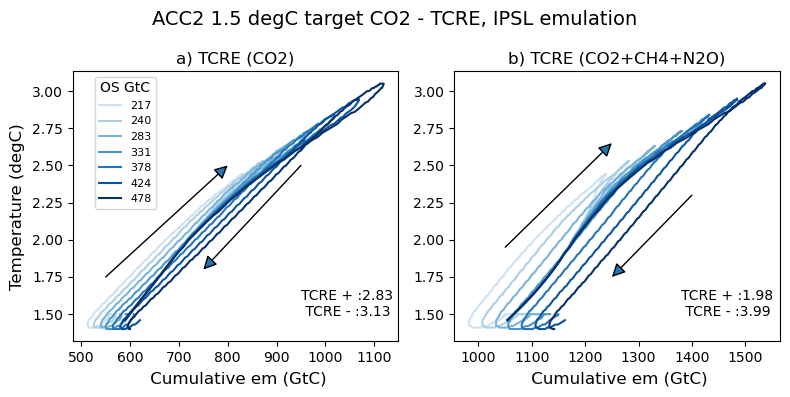

In [20]:
## -------------------- PLOT ---------------------##
from email.base64mime import header_length


title = 'ACC2 1.5 degC target CO2 - TCRE, IPSL emulation'

# Plot configuration
width_inch = 8
height_inch = 4

fig = plt.figure(figsize=(width_inch, height_inch), tight_layout=True)
gs = gridspec.GridSpec(1, 2)

# Plot Ratio N/P
# xlabel = 'Overshoot Amount'
# ylabel = 'Ratio'
# xlabelpad = 5
# ylabelpad = 5
# ax = fig.add_subplot(gs[0, 0])
# ax.plot(OS_co2_15[:],ratio_co2_15[:], marker='o')
# ax.set_xlabel(xlabel, labelpad=xlabelpad, fontsize=12)
# ax.set_ylabel(ylabel, labelpad=ylabelpad, fontsize=12)
# ax.set_title("Ratio N/P emissions")

# Plot TCRE CO2
xlabel = ' Cumulative em (GtC)'
ylabel = 'Temperature (degC)'
xlabelpad = 5
ylabelpad = 5
ax = fig.add_subplot(gs[0, 0])
color = iter(cm.Blues_r(np.linspace(0.8, 0, len(tas_co2_15_acc2.T))))

prop = dict(arrowstyle="-|>,head_width=0.4,head_length=0.8",
            shrinkA=0,shrinkB=0)

overshoot = np.int64(OS_co2_15[:])
for x, item in enumerate(tas_co2_15_acc2.columns):
    c = next(color)
    ax.plot(co2cum_15_acc2.iloc[270:450,x], tas_co2_15_acc2.iloc[270:450,x],label=overshoot, color=c)
ax.annotate("", xytext=(550, 1.75), xy=(800,2.5),  xycoords = 'data', arrowprops=prop)
ax.annotate("", xytext=(950, 2.5), xy=(750,1.8), xycoords = 'data', arrowprops=prop)
ax.legend(overshoot, loc='upper left',title = "OS GtC", title_fontsize = 10, bbox_to_anchor=(0.05, 1), fontsize=8)
ax.set_xlabel(xlabel, labelpad=xlabelpad, fontsize=12)
ax.set_ylabel(ylabel, labelpad=ylabelpad, fontsize=12)
ax.text(950, 1.5,'TCRE + :2.83\n TCRE - :3.13', wrap = True)
ax.set_title("a) TCRE (CO2)")

# Plot TCRE CO2+CH4+N2O
xlabelpad = 5
ylabelpad = 5
ax = fig.add_subplot(gs[0, 1])
color = iter(cm.Blues_r(np.linspace(0.8, 0, len(tas_co2_15_acc2.T))))

overshoot = np.int64(OS_co2_15[:])
for x, item in enumerate(tas_co2_15_acc2.columns):
    c = next(color)
    ax.plot(co2cum_15_acc2_plus.iloc[270:450,x], tas_co2_15_acc2.iloc[270:450,x],label=overshoot, color=c)
ax.annotate("", xytext=(1050, 1.95), xy=(1250,2.65),  xycoords = 'data', arrowprops=prop)
ax.annotate("", xytext=(1400, 2.3), xy=(1250,1.75), xycoords = 'data', arrowprops=prop)
ax.set_xlabel(xlabel, labelpad=xlabelpad, fontsize=12)
ax.text(1380, 1.5,'TCRE + :1.98\n TCRE - :3.99', wrap = True)
ax.set_title("b) TCRE (CO2+CH4+N2O)")

# output file
fig.suptitle(title, fontsize = 14)
output_file = os.path.join(out_path,title.replace(' ','_')) + "_OSem_BETA03.png"

# save the output file
plt.savefig(output_file)